In [1]:
## M1 100%

import pandas as pd 
import numpy as np
import os
ress2 = pd.read_csv('../M1_M1all_prediction_sub512_2048log2LB_#layers2_emb512_s2_y2020.csv', dtype={
    'w_geocode': 'string',
    'h_geocode': 'string'
    })
resl8 = pd.read_csv('../M1_M1all_prediction_sub512_2048log2LB_#layers2_emb512_l8_y2020.csv', dtype={
    'w_geocode': 'string',
    'h_geocode': 'string'
    })
ress2['h_geocode'] = ress2['h_geocode'].apply(lambda x: ('0'+x) if len(x)==10 else x)
ress2['w_geocode'] = ress2['w_geocode'].apply(lambda x: ('0'+x) if len(x)==10 else x)
resl8['h_geocode'] = resl8['h_geocode'].apply(lambda x: ('0'+x) if len(x)==10 else x)
resl8['w_geocode'] = resl8['w_geocode'].apply(lambda x: ('0'+x) if len(x)==10 else x)

population = pd.read_csv("/data/Population_us/DECENNIALDHC2020.P1-Data.csv", header=1)
population = population.rename(columns={' !!Total': 'population'})
population['geoid'] = population['Geography'].apply(lambda x:str(x)[-11:])
# res.set_index(['h_geocode','w_geocode'])
res_total = pd.concat([
        #    res.set_index(['h_geocode','w_geocode']),
           ress2.set_index(['h_geocode','w_geocode']),
           resl8.set_index(['h_geocode','w_geocode'])]
           , axis=1, join="inner")
res_total.drop(columns='Unnamed: 0', inplace=True)
# res_total.columns = ['count', 'prediction_r1w', 'c', 'prediction_s2', 'c', 'prediction_l8']
res_total.columns = ['count', 'prediction_s2', 'c', 'prediction_l8']
# res_total.rename(columns={res_total.columns[1]: "prediction_r1w", res_total.columns[3]: "prediction_s2", res_total.columns[5]: "prediction_l8"}
#                 )
res_total.drop(columns='c'
               ,inplace=True)
res_total = res_total.reset_index()
res_total

,h_geocode,w_geocode,count,prediction_s2,prediction_l8
0,34003010100,34003001001,17.0,29.746943,23.386446
1,34003039200,34003001001,14.0,29.377472,30.621870
2,34003053202,34003001001,12.0,36.613373,23.638342
3,34031256801,34003001001,11.0,8.107142,13.771761
4,36087011303,34003001001,12.0,18.099524,21.768255
...,...,...,...,...,...
120554,36119002103,36119002103,26.0,31.871204,30.353610
120555,36079011201,36079011201,14.0,34.209030,32.117054
120556,36087012203,36087012203,37.0,24.661730,24.346530
120557,36103159201,36103159201,23.0,27.642076,29.682045


In [15]:
def CPC(y_hat, y):
    '''
    Common Part of Commuters Metric
    '''
    return 2 * np.minimum(y_hat, y).sum() / (y_hat.sum() + y.sum()) 

res = res_total.copy()
res.groupby('count').sum()

print(res[res['count']<=20].sum()['freq'], 
      CPC(res[res['count']<=20]['prediction_s2'], res[res['count']<=20]['count']))
print(res[(res['count']>20) & (res['count']<=40)].sum()['freq'],
      CPC(res[(res['count']>20) & (res['count']<=40)]['prediction_s2'], res[(res['count']>20) & (res['count']<=40)]['count']))
print(res[(res['count']<=60) & (res['count']>40)].sum()['freq'],
      CPC(res[(res['count']<=60) & (res['count']>40)]['prediction_s2'], res[(res['count']<=60) & (res['count']>40)]['count']))
print(res[(res['count']<=80) & (res['count']>60)].sum()['freq'],
      CPC(res[(res['count']<=80) & (res['count']>60)]['prediction_s2'], res[(res['count']<=80) & (res['count']>60)]['count']))
print(res[(res['count']<=100) & (res['count']>80)].sum()['freq'],
      CPC(res[(res['count']<=100) & (res['count']>80)]['prediction_s2'], res[(res['count']<=100) & (res['count']>80)]['count']))
print(res[(res['count']>100)].sum()['freq'],
      CPC(res[(res['count']>100)]['prediction_s2'], res[(res['count']>100)]['count']))

c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys


79724 0.80545102746344
29644 0.8476113285088358
6788 0.752253885128625
2394 0.6644382574038369
953 0.5836223090644619
1056 0.42994460308331883


c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == "__main__":
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  del sys.path[0]
c:\Pr

In [17]:
# population分级
import pickle

population = population[population['geoid'].isin(res_total['h_geocode'].unique())]
labels_p = [ i for i in range(10, 0, -1) ]
population['Decile_rank'] = pd.qcut(population['population'], 10, 
                            labels = labels_p)
population

,Geography,Geographic Area Name,population,Unnamed: 3,geoid,Decile_rank
47013,1400000US34003001001,Census Tract 10.01; Bergen County; New Jersey,3363,NaN,34003001001,7
47014,1400000US34003001002,Census Tract 10.02; Bergen County; New Jersey,3485,NaN,34003001002,7
47015,1400000US34003002100,Census Tract 21; Bergen County; New Jersey,1762,NaN,34003002100,10
47016,1400000US34003002200,Census Tract 22; Bergen County; New Jersey,5168,NaN,34003002200,3
47017,1400000US34003002300,Census Tract 23; Bergen County; New Jersey,5641,NaN,34003002300,2
...,...,...,...,...,...,...
66403,1400000US42103950804,Census Tract 9508.04; Pike County; Pennsylvania,3727,NaN,42103950804,6
66404,1400000US42103950805,Census Tract 9508.05; Pike County; Pennsylvania,2903,NaN,42103950805,8
66405,1400000US42103950806,Census Tract 9508.06; Pike County; Pennsylvania,2783,NaN,42103950806,8
66406,1400000US42103950901,Census Tract 9509.01; Pike County; Pennsylvania,2512,NaN,42103950901,9


In [18]:
# Land use
import geopandas as gpd
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

shapefile_path = '/data/Landuse/Tabulat_value_M1.dbf' 
gdf_lu = gpd.read_file(shapefile_path)
gdf_lu['sum'] = gdf_lu['VALUE_11']+gdf_lu['VALUE_21']+gdf_lu['VALUE_22']+gdf_lu['VALUE_23']+gdf_lu['VALUE_24']+gdf_lu['VALUE_31']+gdf_lu['VALUE_41']+gdf_lu['VALUE_42']+gdf_lu['VALUE_43']+gdf_lu['VALUE_52']+gdf_lu['VALUE_71']+gdf_lu['VALUE_81']+gdf_lu['VALUE_82']+gdf_lu['VALUE_90']+gdf_lu['VALUE_95']
gdf_lu['ratio_22_23_24'] = (gdf_lu['VALUE_21']+gdf_lu['VALUE_22']+gdf_lu['VALUE_23']) / gdf_lu['sum']
labels_a = [ i for i in range(10, 0, -1) ]
gdf_lu['developed_ratio_rank'] = pd.qcut(gdf_lu['ratio_22_23_24'], 10, 
                            labels = labels_a)

gdf_lu = gdf_lu.drop(columns='geometry')
gdf_lu = gdf_lu.set_index('GEOID20')
gdf_lu['SUM_22_23_24'] = gdf_lu['VALUE_22'] + gdf_lu['VALUE_23'] + gdf_lu['VALUE_24']
gdf_lu['SUM_4'] = gdf_lu['VALUE_41'] + gdf_lu['VALUE_42'] + gdf_lu['VALUE_43']
gdf_lu['SUM_8'] = gdf_lu['VALUE_81'] + gdf_lu['VALUE_82']
gdf_lu['SUM_9'] = gdf_lu['VALUE_90'] + gdf_lu['VALUE_95']
print(gdf_lu[[
    # 'VALUE_0', 
    'VALUE_11', 'VALUE_21', 'SUM_22_23_24', 'VALUE_31', 'SUM_4', 'VALUE_52', 'VALUE_71', 'SUM_8', 'SUM_9']].sum())

gdf_lu = gdf_lu[[
    # 'VALUE_0', 
                 'VALUE_11', 'VALUE_21', 'SUM_22_23_24', 'VALUE_31', 'SUM_4', 'VALUE_52', 'VALUE_71', 'SUM_8', 'SUM_9']]
gdf_lu['max_class'] = gdf_lu.idxmax(axis=1)

gdf_lu

VALUE_11        6.424606e+09
VALUE_21        2.593972e+09
SUM_22_23_24    5.240250e+09
VALUE_31        1.408410e+08
SUM_4           6.135656e+09
VALUE_52        7.646220e+07
VALUE_71        1.187406e+08
SUM_8           1.195045e+09
SUM_9           1.931636e+09
dtype: float64


,VALUE_11,VALUE_21,SUM_22_23_24,VALUE_31,SUM_4,VALUE_52,VALUE_71,SUM_8,SUM_9,max_class
GEOID20,,,,,,,,,,
42103950102,3303900.0,7382700.0,1265400.0,27900.0,99576000.0,121500.0,330300.0,1262700.0,7706700.0,SUM_4
42103950103,215100.0,277200.0,1199700.0,0.0,59400.0,0.0,2700.0,65700.0,200700.0,SUM_22_23_24
42103950104,1596600.0,3661200.0,3042000.0,42300.0,63449100.0,126900.0,252000.0,982800.0,3242700.0,SUM_4
42103950202,901800.0,3303900.0,884700.0,54900.0,76824000.0,227700.0,392400.0,460800.0,5111100.0,SUM_4
42103950203,1538100.0,5626800.0,1382400.0,82800.0,35312400.0,130500.0,285300.0,621900.0,2273400.0,SUM_4
...,...,...,...,...,...,...,...,...,...,...
34035053405,16200.0,2660400.0,4150800.0,23400.0,4820400.0,749700.0,155700.0,8961300.0,3826800.0,SUM_8
34035054302,36900.0,2145600.0,2755800.0,2700.0,856800.0,34200.0,19800.0,160200.0,940500.0,SUM_22_23_24
34035054301,67500.0,1326600.0,3717000.0,2700.0,742500.0,166500.0,7200.0,488700.0,751500.0,SUM_22_23_24


In [19]:
# res_total['common_r1w'] = res_total[['prediction_r1w','count']].min(axis=1)
res_total['common_s2'] = res_total[['prediction_s2','count']].min(axis=1)
res_total['common_l8'] = res_total[['prediction_l8','count']].min(axis=1)

In [20]:
population = population.set_index('geoid')
# gdf_lu = gdf_lu.set_index('GEOID20')
home_sum = res_total.groupby('h_geocode').sum()
for index, row in home_sum.iterrows():
    home_sum.at[index, 'population'] = population.loc[str(index)]['population']
    home_sum.at[index, 'decile'] = population.loc[str(index)]['Decile_rank']
    try:
        home_sum.at[index, 'LC'] = gdf_lu.loc[str(index)]['max_class']
    except KeyError:
        home_sum.at[index, 'LC'] = 'UNKNOWN'
    # home_sum.at[index, 'developed_ratio'] = gdf_lu.loc[str(index)]['ratio_22_23_24']
    # home_sum.at[index, 'developed_decile'] = gdf_lu.loc[str(index)]['developed_ratio_rank']
    # home_sum.at[index, 'developed_25'] = gdf_lu.loc[str(index)]['developed_ratio_25']
# home_sum['h_cpc_r1w'] = 2 * home_sum['common_r1w'] / (home_sum['count']+home_sum['prediction_r1w'])
home_sum['h_cpc_s2'] = 2 * home_sum['common_s2'] / (home_sum['count']+home_sum['prediction_s2'])
home_sum['h_cpc_l8'] = 2 * home_sum['common_l8'] / (home_sum['count']+home_sum['prediction_l8'])
home_sum

,count,prediction_s2,prediction_l8,common_s2,common_l8,population,decile,LC,h_cpc_s2,h_cpc_l8
h_geocode,,,,,,,,,,
34003001001,313.0,489.406306,450.361290,301.391786,313.000000,3363.0,7.0,VALUE_21,0.751220,0.820057
34003001002,372.0,448.082289,568.911912,315.186548,337.350900,3485.0,7.0,VALUE_21,0.768671,0.717072
34003002100,92.0,95.224959,106.271005,86.063395,90.829836,1762.0,10.0,SUM_4,0.919358,0.916219
34003002200,762.0,703.684171,830.537154,495.934703,519.016789,5168.0,3.0,SUM_22_23_24,0.676728,0.651811
34003002300,843.0,680.429246,731.949966,555.363049,561.592823,5641.0,2.0,VALUE_21,0.729096,0.713156
...,...,...,...,...,...,...,...,...,...,...
42103950804,97.0,133.737458,227.830450,93.613148,97.000000,3727.0,6.0,SUM_4,0.811426,0.597235
42103950805,43.0,35.867070,54.171688,35.867070,43.000000,2903.0,8.0,SUM_4,0.909558,0.885031
42103950806,68.0,78.367871,130.619160,65.936665,68.000000,2783.0,8.0,SUM_4,0.900972,0.684727


Land Use

In [21]:
import geopandas as gpd
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

shapefile_path = '/data/Landuse/Tabulat_LU_M1.dbf' # 2327
lu = gpd.read_file(shapefile_path)
lu = pd.DataFrame(lu)
lu = lu.set_index('GEOID20')
lu = lu.drop(columns='geometry')
lu['max_class'] = lu.idxmax(axis=1)
# home_sum = home_sum.set_index('h_geocode')
for index, row in home_sum.iterrows():
    try:
        home_sum.at[index, 'LU'] = lu.loc[str(index)]['max_class']
    except KeyError:
        home_sum.at[index, 'LU'] = 'UNKNOWN'

In [22]:
home_sum

,count,prediction_s2,prediction_l8,common_s2,common_l8,population,decile,LC,h_cpc_s2,h_cpc_l8,LU
h_geocode,,,,,,,,,,,
34003001001,313.0,489.406306,450.361290,301.391786,313.000000,3363.0,7.0,VALUE_21,0.751220,0.820057,VALUE_6
34003001002,372.0,448.082289,568.911912,315.186548,337.350900,3485.0,7.0,VALUE_21,0.768671,0.717072,VALUE_6
34003002100,92.0,95.224959,106.271005,86.063395,90.829836,1762.0,10.0,SUM_4,0.919358,0.916219,VALUE_6
34003002200,762.0,703.684171,830.537154,495.934703,519.016789,5168.0,3.0,SUM_22_23_24,0.676728,0.651811,VALUE_6
34003002300,843.0,680.429246,731.949966,555.363049,561.592823,5641.0,2.0,VALUE_21,0.729096,0.713156,VALUE_6
...,...,...,...,...,...,...,...,...,...,...,...
42103950804,97.0,133.737458,227.830450,93.613148,97.000000,3727.0,6.0,SUM_4,0.811426,0.597235,UNKNOWN
42103950805,43.0,35.867070,54.171688,35.867070,43.000000,2903.0,8.0,SUM_4,0.909558,0.885031,VALUE_6
42103950806,68.0,78.367871,130.619160,65.936665,68.000000,2783.0,8.0,SUM_4,0.900972,0.684727,UNKNOWN


In [23]:
home_sum['error_s2'] = (home_sum['prediction_s2'] - home_sum['count']) / home_sum['count']
home_sum['error_l8'] = (home_sum['prediction_l8'] - home_sum['count']) / home_sum['count']
home_sum = home_sum.reset_index()
home_sum['h_geocode_str'] = home_sum['h_geocode'].apply(lambda x: ('\''+str(x)))
home_sum.to_csv('M1_log2LB_home_decile_cpc_sub512.csv')

# plot

    decile count  CPC s2 mean  CPC l8 mean
0  VALUE_2   440     0.813005     0.809498
1  VALUE_3    68     0.806932     0.805411
2  VALUE_4     7     0.769105     0.726771
3  VALUE_5  1302     0.836746     0.829236


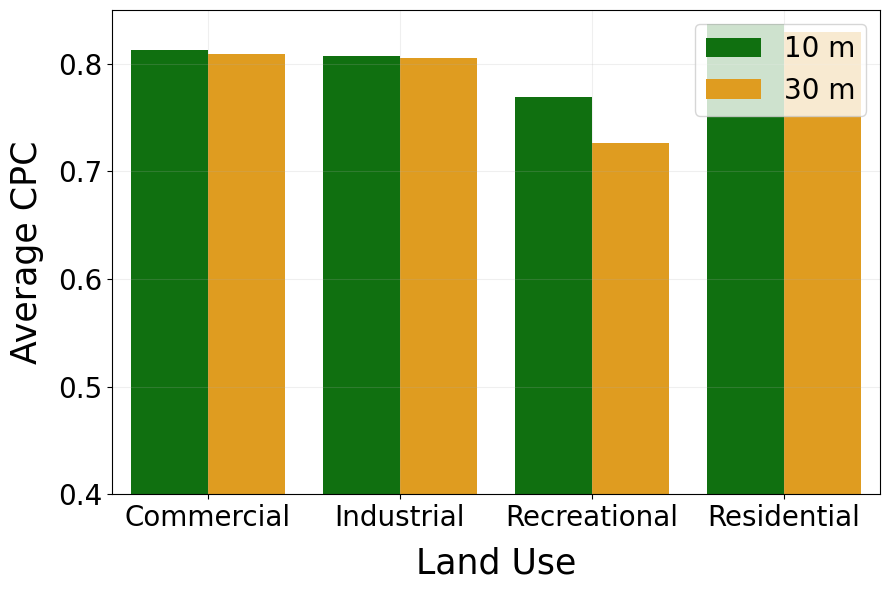

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import json
import seaborn as sns

save_name = './M1_fig/M1_LU.png'
if os.path.exists(os.path.dirname(save_name))==False:
    os.mkdir(os.path.dirname(save_name))
column_name = 'LU'
axisx_label = 'Land Use'
# x_ticklabels = ['built up', 'forest','cultivated', 'wetlands', 'water', 'open space']
x_ticklabels = [ 'Commercial','Industrial', 'Recreational', 'Residential']
df = home_sum
x_ticks = len(x_ticklabels)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), sharex=True)

# st = fig.suptitle(country_to_string[country], fontsize=30)

# avg_originals, avg_deeps, avg_originals_p, avg_deeps_p, avg_dg_sums = [], [], [], [], []
# std_originals, std_deeps, std_originals_p, std_deeps_p, std_dg_sums = [], [], [], [], []
avg_r1ws,avg_s2s,avg_l8s = [], [], []
std_r1ws,std_s2s,std_l8s = [], [], []

table = pd.DataFrame(columns=['decile','count',
                            #   'CPC r1w mean',
                                'CPC s2 mean','CPC l8 mean'])
# for decile in sorted(df[column_name].unique()):
for decile in ['VALUE_2', 'VALUE_3', 'VALUE_4', 'VALUE_5']:
    df_temp = df[df[column_name] == decile]

    # avg_r1w = df_temp.h_cpc_r1w.mean()
    avg_s2 = df_temp.h_cpc_s2.mean()
    avg_l8 = df_temp.h_cpc_l8.mean()
    

    # avg_r1ws.append(avg_r1w)
    avg_s2s.append(avg_s2)
    avg_l8s.append(avg_l8)

    # std_r1w = df_temp.h_cpc_r1w.std()
    std_s2 = df_temp.h_cpc_s2.std()
    std_l8 = df_temp.h_cpc_l8.std()

    # std_r1ws.append(std_r1w)
    std_s2s.append(std_s2)
    std_l8s.append(std_l8)

    table = table.append({'decile':decile,
                'count':len(df_temp),
            #    'CPC r1w mean':avg_r1w,
                'CPC s2 mean':avg_s2,
                'CPC l8 mean':avg_l8}
                ,ignore_index=True)

print(table)
table_s2 = table[['decile', 'count', 'CPC s2 mean']].rename(columns={'CPC s2 mean':'mean_cpc'})
table_s2['resolution'] = '10 m'
table_l8 = table[['decile', 'count', 'CPC l8 mean']].rename(columns={'CPC l8 mean':'mean_cpc'})
table_l8['resolution'] = '30 m'
table_2 = pd.concat([table_s2, table_l8])

sns.barplot(table_2, x="decile", y="mean_cpc", hue="resolution", palette=['green', 'orange'])

# ax.bar(range(x_ticks), avg_s2s, 
#         color='green', label='10 m')  

# ax.bar(range(x_ticks), avg_l8s, 
#         color='orange', label='30 m')  


# ax.errorbar(range(10), avg_originals, yerr=std_originals, marker='s',
#           color='darkgrey', linewidth=2, 
#           label='MFG', markersize=8)

ax.set_ylabel('Average CPC', fontsize=25, labelpad=10)
ax.set_xlabel(axisx_label, fontsize=25, labelpad=10)
ax.set_xticks(range(x_ticks))
ax.set_xticklabels(x_ticklabels)

ax.set_ylim(0.40,0.85)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)
# ax.set_title(country_to_subid[country][0], fontsize=30)
ax.legend(fontsize=20, loc='upper right')

plt.subplots_adjust(wspace=0.3)
#fig.suptitle(country2long_name[country], fontsize=20)
plt.tight_layout()
plt.savefig(save_name)

         decile count  CPC s2 mean  CPC l8 mean
0      VALUE_21   171     0.782695     0.782316
1  SUM_22_23_24  4045     0.809644     0.803961
2         SUM_4   277     0.754445     0.749489
3         SUM_8    22     0.731263     0.719648
4         SUM_9    40     0.765937     0.763361


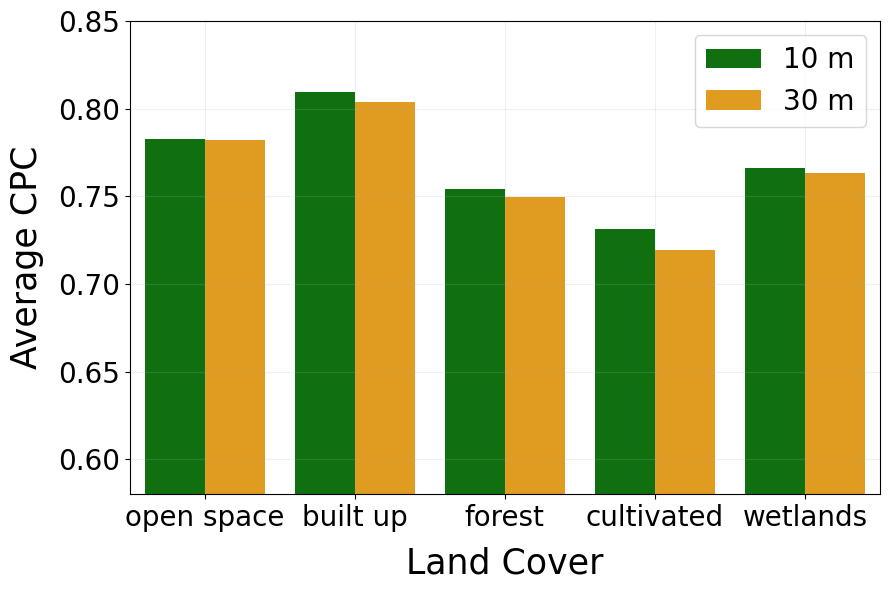

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json
save_name = './M1_fig/M1_LC.png'

column_name = 'LC'
axisx_label = 'Land Cover'
# x_ticklabels = ['built up', 'forest','cultivated', 'wetlands', 'water', 'open space']
x_ticklabels = ['open space', 'built up', 'forest', 'cultivated', 'wetlands']
df = home_sum
x_ticks = len(x_ticklabels)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), sharex=True)

# st = fig.suptitle(country_to_string[country], fontsize=30)

# avg_originals, avg_deeps, avg_originals_p, avg_deeps_p, avg_dg_sums = [], [], [], [], []
# std_originals, std_deeps, std_originals_p, std_deeps_p, std_dg_sums = [], [], [], [], []
avg_r1ws,avg_s2s,avg_l8s = [], [], []
std_r1ws,std_s2s,std_l8s = [], [], []

table = pd.DataFrame(columns=['decile','count',
                            #   'CPC r1w mean',
                                'CPC s2 mean','CPC l8 mean'])
# for decile in sorted(df[column_name].unique()):
for decile in ['VALUE_21', 'SUM_22_23_24', 'SUM_4', 'SUM_8', 'SUM_9']:
    df_temp = df[df[column_name] == decile]

    # avg_r1w = df_temp.h_cpc_r1w.mean()
    avg_s2 = df_temp.h_cpc_s2.mean()
    avg_l8 = df_temp.h_cpc_l8.mean()
    

    # avg_r1ws.append(avg_r1w)
    avg_s2s.append(avg_s2)
    avg_l8s.append(avg_l8)

    # std_r1w = df_temp.h_cpc_r1w.std()
    std_s2 = df_temp.h_cpc_s2.std()
    std_l8 = df_temp.h_cpc_l8.std()

    # std_r1ws.append(std_r1w)
    std_s2s.append(std_s2)
    std_l8s.append(std_l8)

    table = table.append({'decile':decile,
                'count':len(df_temp),
            #    'CPC r1w mean':avg_r1w,
                'CPC s2 mean':avg_s2,
                'CPC l8 mean':avg_l8}
                ,ignore_index=True)

print(table)


table_s2 = table[['decile', 'count', 'CPC s2 mean']].rename(columns={'CPC s2 mean':'mean_cpc'})
table_s2['resolution'] = '10 m'
table_l8 = table[['decile', 'count', 'CPC l8 mean']].rename(columns={'CPC l8 mean':'mean_cpc'})
table_l8['resolution'] = '30 m'
table_2 = pd.concat([table_s2, table_l8])

sns.barplot(table_2, x="decile", y="mean_cpc", hue="resolution", palette=['green', 'orange'])

# ax.errorbar(range(10), avg_originals, yerr=std_originals, marker='s',
#           color='darkgrey', linewidth=2, 
#           label='MFG', markersize=8)

ax.set_ylabel('Average CPC', fontsize=25, labelpad=10)
ax.set_xlabel(axisx_label, fontsize=25, labelpad=10)
ax.set_xticks(range(x_ticks))
ax.set_xticklabels(x_ticklabels)

ax.set_ylim(0.58,0.85)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)
# ax.set_title(country_to_subid[country][0], fontsize=30)
ax.legend(fontsize=20, loc='upper right')

plt.subplots_adjust(wspace=0.3)
#fig.suptitle(country2long_name[country], fontsize=20)
plt.tight_layout()
plt.savefig(save_name)

In [30]:
def plot_decile(df, column_name, axisx_label,x_ticklabels, x_ticks,savename):
   fig, axes = plt.subplots(1, 1, figsize=(9, 6), sharex=True)

   # st = fig.suptitle(country_to_string[country], fontsize=30)

   # avg_originals, avg_deeps, avg_originals_p, avg_deeps_p, avg_dg_sums = [], [], [], [], []
   # std_originals, std_deeps, std_originals_p, std_deeps_p, std_dg_sums = [], [], [], [], []
   avg_r1ws,avg_s2s,avg_l8s = [], [], []
   std_r1ws,std_s2s,std_l8s = [], [], []

   table = pd.DataFrame(columns=['decile','count',
                              #   'CPC r1w mean',
                                 'CPC s2 mean','CPC l8 mean'])
   for decile in sorted(df[column_name].unique()):
      df_temp = df[df[column_name] == decile]

      # avg_r1w = df_temp.h_cpc_r1w.mean()
      avg_s2 = df_temp.h_cpc_s2.mean()
      avg_l8 = df_temp.h_cpc_l8.mean()
      

      # avg_r1ws.append(avg_r1w)
      avg_s2s.append(avg_s2)
      avg_l8s.append(avg_l8)

      # std_r1w = df_temp.h_cpc_r1w.std()
      std_s2 = df_temp.h_cpc_s2.std()
      std_l8 = df_temp.h_cpc_l8.std()

      # std_r1ws.append(std_r1w)
      std_s2s.append(std_s2)
      std_l8s.append(std_l8)

      table = table.append({'decile':decile,
                  'count':len(df_temp),
               #    'CPC r1w mean':avg_r1w,
                  'CPC s2 mean':avg_s2,
                  'CPC l8 mean':avg_l8}
                  ,ignore_index=True)

   print(table)

   # decile plots
   ax = axes

   # ax.errorbar(range(10), avg_r1ws, yerr=std_r1w, marker='o',
   #           color='blue', label='5 m', linewidth=3, markersize=10)

   ax.errorbar(range(x_ticks), avg_s2s, yerr=std_s2s, marker='v',
            color='green', label='10 m', linewidth=1, markersize=10, zorder=3)  

   ax.errorbar(range(x_ticks), avg_l8s, yerr=std_l8s,
            color='orange', label='30 m', linestyle='--', linewidth=3)  


   # ax.errorbar(range(10), avg_originals, yerr=std_originals, marker='s',
   #           color='darkgrey', linewidth=2, 
   #           label='MFG', markersize=8)

   ax.set_ylabel('Average CPC', fontsize=25)
   ax.set_xlabel(axisx_label, fontsize=25)
   ax.set_xticks(range(x_ticks))
   ax.set_xticklabels(x_ticklabels)
   ax.set_ylim(-0.05,1)
   ax.tick_params(labelsize=20)
   ax.grid(alpha=0.2)
   # ax.set_title(country_to_subid[country][0], fontsize=30)
   ax.legend(fontsize=20, loc='lower right')

   # relative improvement plot

   # ax = axes[1]

   # ax.plot(range(len(relative_improve_original_p_deep)), relative_improve_original_p_deep, color=main_color, linewidth=3, 
   #       marker='o', markersize=10)

   # ax.plot(range(len(relative_improve_original_p_deep_p)), relative_improve_original_p_deep_p, color='lightgrey', linewidth=2, 
   #       marker='v', markersize=8)

   # ax.plot(range(len(relative_improve_original_p_original)), relative_improve_original_p_original, color='darkgrey', linewidth=2, 
   #       marker='s', markersize=10)

   # ax.set_ylabel('Relative improvement (%)', fontsize=25)
   # ax.set_xlabel('Decile population', fontsize=25)
   # ax.set_ylim(0,max(relative_improve_original_p_deep)+max(relative_improve_original_p_deep)*0.1)
   # ax.tick_params(labelsize=20)
   # ax.set_title(country_to_subid[country][1], fontsize=30)
   # ax.grid(alpha=0.2)



   plt.subplots_adjust(wspace=0.3)
   #fig.suptitle(country2long_name[country], fontsize=20)
   plt.tight_layout()
   plt.savefig(savename)

   decile  count  CPC s2 mean  CPC l8 mean
0     1.0  479.0     0.775756     0.759965
1     2.0  478.0     0.785481     0.777741
2     3.0  478.0     0.791807     0.787530
3     4.0  478.0     0.799526     0.797702
4     5.0  478.0     0.804513     0.802576
5     6.0  479.0     0.810518     0.804360
6     7.0  479.0     0.811506     0.808429
7     8.0  477.0     0.813012     0.808545
8     9.0  481.0     0.825815     0.818572
9    10.0  479.0     0.806162     0.807389


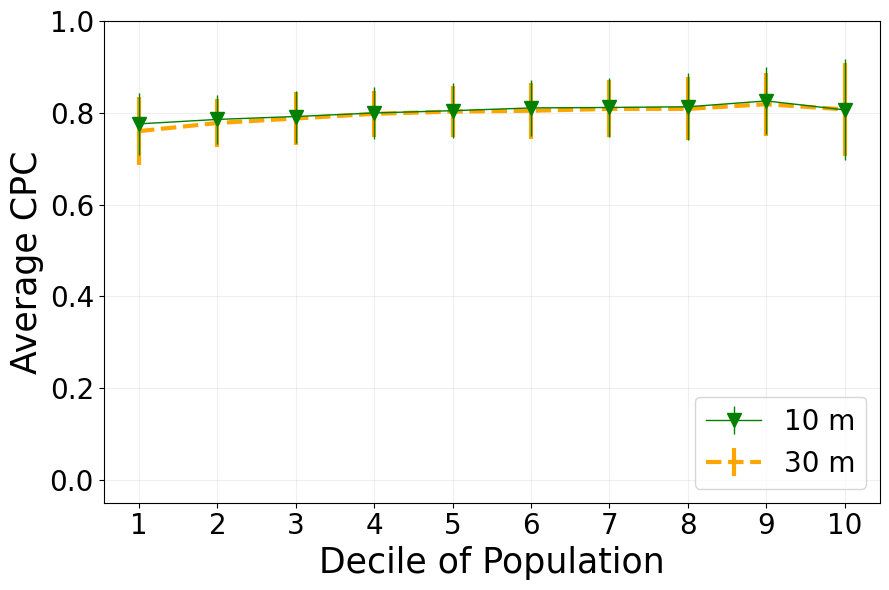

In [31]:
plot_decile(home_sum, 'decile', 'Decile of Population', range(1,11), 10, './M1_fig/M1_Population.png')

# flow distance

In [32]:
import geopandas as gpd
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd

feat = gpd.read_file('/data/M1_NY/CensusTracts/tl_2020_tract20_M1.shp')
feat['centroid_x'] = feat['geometry'].centroid.x
feat['centroid_y'] = feat['geometry'].centroid.y
res_total = pd.merge(left=res_total, right=feat, left_on='h_geocode', right_on='GEOID20')[['w_geocode', 'h_geocode', 'count','prediction_s2','prediction_l8', 'centroid_x', 'centroid_y']]
res_total = res_total.rename(columns={'centroid_x': "h_centroid_x", 'centroid_y':'h_centroid_y'})
res_total = pd.merge(left=res_total, right=feat, left_on='w_geocode', right_on='GEOID20')[['w_geocode', 'h_geocode', 'count','prediction_s2','prediction_l8','h_centroid_x', 'h_centroid_y', 'centroid_x', 'centroid_y']]
res_total = res_total.rename(columns={'centroid_x': "w_centroid_x", 'centroid_y':'w_centroid_y'})

c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys
c:\ProgramData\Anaconda3\envs\cuda10.1\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [33]:
res_total.to_csv('flows_log2LB_M1_2020_xy.csv')
res_total

,w_geocode,h_geocode,count,prediction_s2,prediction_l8,h_centroid_x,h_centroid_y,w_centroid_x,w_centroid_y
0,34003001001,34003010100,17.0,29.746943,23.386446,-73.982323,40.945956,-74.125119,41.036409
1,34003001001,34003039200,14.0,29.377472,30.621870,-74.220476,41.037143,-74.125119,41.036409
2,34003001001,34003053202,12.0,36.613373,23.638342,-74.101209,41.070978,-74.125119,41.036409
3,34003001001,34031256801,11.0,8.107142,13.771761,-74.389836,41.169534,-74.125119,41.036409
4,34003001001,36087011303,12.0,18.099524,21.768255,-74.000297,41.093223,-74.125119,41.036409
...,...,...,...,...,...,...,...,...,...
120554,34029716000,34029716000,16.0,27.487532,44.279232,-74.167491,40.039755,-74.167491,40.039755
120555,36081118100,36081118100,12.0,13.151745,22.104898,-73.787359,40.759500,-73.787359,40.759500
120556,36047041402,36047041402,16.0,22.748580,17.626944,-73.967936,40.602423,-73.967936,40.602423
120557,36005011701,36005011701,16.0,17.194777,31.481290,-73.883598,40.814391,-73.883598,40.814391


In [34]:
# 计算距离
from shapely.geometry import Point
import geopy.distance

def haversine(o_x, o_y, d_x, d_y):
    # Extract latitude and longitude from the Shapely Point objects
    # lat1, lon1 = point1.y, point1.x
    # lat2, lon2 = point2.y, point2.x

    # Use geopy.distance.distance to calculate the distance
    distance = geopy.distance.distance((o_y, o_x), (d_y, d_x)).m

    return distance
# # Example usage
# point1 = Point(-122.4194, 37.7749)  # San Francisco, CA
# point2 = Point(-118.2437, 34.0522)  # Los Angeles, CA

# distance = haversine(point1, point2)
# print(f"Distance between the two points: {distance:.2f} m")

In [35]:
from tqdm import tqdm
from tqdm.gui import tqdm as tqdm_gui
tqdm.pandas(ncols=50)
res_total['distance'] = res_total.progress_apply(lambda row: haversine(row['h_centroid_x'], row['h_centroid_y'], row['w_centroid_x'], row['w_centroid_y']), axis=1)

  0%|                  | 0/120559 [00:00<?, ?it/s]

100%|███| 120559/120559 [00:49<00:00, 2459.92it/s]


In [36]:
res_total.quantile([0.2,0.4,0.6,0.8,1])

,count,prediction_s2,prediction_l8,h_centroid_x,h_centroid_y,w_centroid_x,w_centroid_y,distance
0.2,12.0,15.070027,14.980820,-74.213875,40.636470,-74.176693,40.686089,3425.314587
0.4,15.0,18.343151,18.136277,-74.002720,40.714481,-74.004721,40.737109,6731.630535
0.6,19.0,21.958750,21.516341,-73.939929,40.773700,-73.982353,40.756452,10813.915524
0.8,27.0,27.577592,26.621060,-73.763736,40.866223,-73.836015,40.820417,17472.238289
1.0,861.0,479.572540,249.171720,-71.915746,41.530480,-71.915746,41.530480,131521.557328


In [37]:
import jenkspy

breaks = jenkspy.jenks_breaks(res_total['distance'], n_classes=5)
print(breaks)

[0.0, 7438.899345484081, 15967.498214071229, 27853.61249029443, 47483.7582495107, 131521.5573284121]


In [40]:
res_total['common_s2'] = res_total[['prediction_s2','count']].min(axis=1)
res_total['common_l8'] = res_total[['prediction_l8','count']].min(axis=1)

res_total['cut'] = pd.cut(res_total['distance'],
                        bins=[0,10000,20000,30000,40000,50000,res_total['distance'].max()],
                        labels=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'],include_lowest=True)
res_total['f_cpc_s2'] = 2* res_total['common_s2'] / (res_total['count']+res_total['prediction_s2'])
res_total['f_cpc_l8'] = 2* res_total['common_l8'] / (res_total['count']+res_total['prediction_l8'])
res_total.groupby('cut').mean()

,count,prediction_s2,prediction_l8,h_centroid_x,h_centroid_y,w_centroid_x,w_centroid_y,distance,common_s2,common_l8,f_cpc_s2,f_cpc_l8
cut,,,,,,,,,,,,
d1,25.521638,23.731302,22.355797,-73.956395,40.732338,-73.963712,40.735416,4820.091640,18.980373,18.225799,0.803034,0.800438
d2,18.848127,20.442079,20.692786,-73.950830,40.732548,-73.974176,40.733030,14086.617492,15.963016,15.910972,0.827724,0.821015
d3,17.351489,19.329074,19.887057,-73.974707,40.729366,-74.004576,40.713416,24196.373523,14.867222,14.980374,0.827131,0.822581
d4,16.112956,17.695870,18.323779,-73.938895,40.767403,-73.991797,40.731930,34320.620022,14.033757,14.126655,0.846555,0.837622
d5,15.223536,17.179150,18.191953,-73.831016,40.747713,-73.972333,40.727127,44029.787148,13.601106,13.782550,0.854256,0.841554
d6,14.260933,15.962767,16.636118,-73.662710,40.825972,-73.961280,40.725504,62184.626047,12.897344,12.947156,0.865026,0.854918


In [41]:
res_total_dis = res_total.groupby('cut').sum()
# home_sum['h_cpc_r1w'] = 2 * home_sum['common_r1w'] / (home_sum['count']+home_sum['prediction_r1w'])
res_total_dis['cpc_s2'] = 2 * res_total_dis['common_s2'] / (res_total_dis['count']+res_total_dis['prediction_s2'])
res_total_dis['cpc_l8'] = 2 * res_total_dis['common_l8'] / (res_total_dis['count']+res_total_dis['prediction_l8'])
res_total_dis

,count,prediction_s2,prediction_l8,h_centroid_x,h_centroid_y,w_centroid_x,w_centroid_y,distance,common_s2,common_l8,f_cpc_s2,f_cpc_l8,cpc_s2,cpc_l8
cut,,,,,,,,,,,,,,
d1,1741469.0,1.619305e+06,1.525448e+06,-5.046415e+06,2.779371e+06,-5.046914e+06,2.779581e+06,3.288990e+08,1.295126e+06,1.243637e+06,54795.003854,54617.894850,0.770731,0.761352
d2,625362.0,6.782477e+05,6.865660e+05,-2.453615e+06,1.351465e+06,-2.454389e+06,1.351481e+06,4.673799e+08,5.296369e+05,5.279102e+05,27463.042224,27240.467593,0.812570,0.804785
d3,198154.0,2.207380e+05,2.271102e+05,-8.447912e+05,4.651294e+05,-8.451323e+05,4.649472e+05,2.763226e+08,1.697837e+05,1.710759e+05,9445.835211,9393.873315,0.810632,0.804563
d4,73749.0,8.099399e+04,8.386793e+04,-3.384183e+05,1.865924e+05,-3.386605e+05,1.864300e+05,1.570855e+08,6.423250e+04,6.465770e+04,3874.680160,3833.795140,0.830183,0.820441
d5,27037.0,3.051017e+04,3.230891e+04,-1.311239e+05,7.236794e+04,-1.313749e+05,7.233138e+04,7.819690e+07,2.415556e+04,2.447781e+04,1517.157990,1494.599176,0.839505,0.824920
d6,19566.0,2.190092e+04,2.282475e+04,-1.010652e+05,5.601323e+04,-1.014749e+05,5.587539e+04,8.531731e+07,1.769516e+04,1.776350e+04,1186.815936,1172.947889,0.853459,0.838084


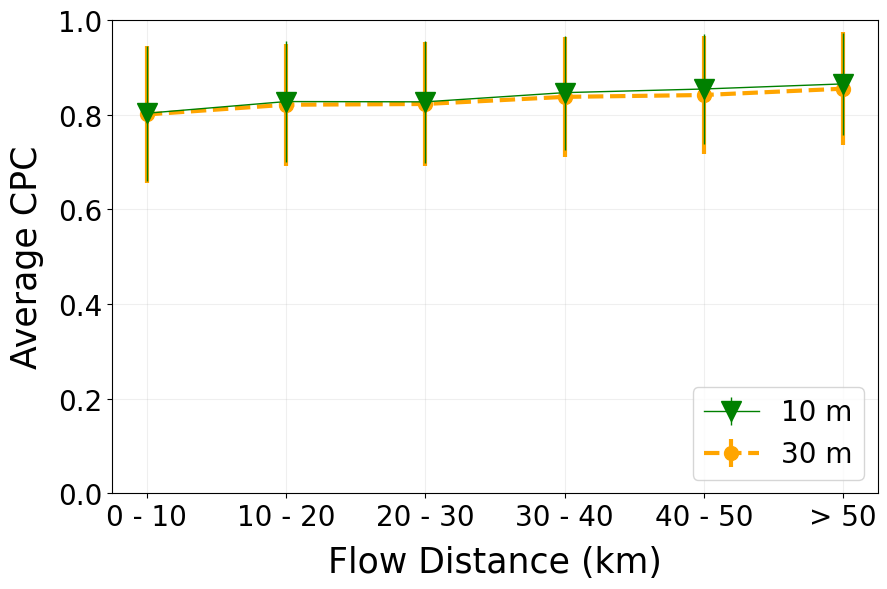

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json
import seaborn as sns

save_name = './M1_fig/M1_flowdis.png'

column_name = 'cut'
axisx_label = 'Flow Distance (km)'
# [0.0, 6841.707559636252, 15961.059075733567, 29481.087492216324, 52608.85742812191, 171166.29727487377]
x_ticklabels = [ '0 - 10','10 - 20', '20 - 30', '30 - 40', '40 - 50', '> 50']

x_ticks = len(x_ticklabels)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), sharex=True)
df = res_total
avg_r1ws,avg_s2s,avg_l8s = [], [], []
std_r1ws,std_s2s,std_l8s = [], [], []
for decile in sorted(df[column_name].unique()):
      df_temp = df[df[column_name] == decile]

      # avg_r1w = df_temp.h_cpc_r1w.mean()
      avg_s2 = df_temp.f_cpc_s2.mean()
      avg_l8 = df_temp.f_cpc_l8.mean()
      

      # avg_r1ws.append(avg_r1w)
      avg_s2s.append(avg_s2)
      avg_l8s.append(avg_l8)

      # std_r1w = df_temp.h_cpc_r1w.std()
      std_s2 = df_temp.f_cpc_s2.std()
      std_l8 = df_temp.f_cpc_l8.std()

      # std_r1ws.append(std_r1w)
      std_s2s.append(std_s2)
      std_l8s.append(std_l8)

      table = table.append({'decile':decile,
                  'count':len(df_temp),
               #    'CPC r1w mean':avg_r1w,
                  'CPC s2 mean':avg_s2,
                  'CPC l8 mean':avg_l8}
                  ,ignore_index=True)

ax.errorbar(range(x_ticks), avg_s2s, yerr=std_s2s, marker='v',
         color='green', label='10 m', linewidth=1, markersize=15, zorder=3)  

ax.errorbar(range(x_ticks), avg_l8s, yerr=std_l8s, marker='o',markersize=10,
         color='orange', label='30 m', linestyle='--', linewidth=3)  

ax.set_ylabel('Average CPC', fontsize=25, labelpad=10)
ax.set_xlabel(axisx_label, fontsize=25, labelpad=10)
ax.set_xticks(range(x_ticks))
ax.set_xticklabels(x_ticklabels)

ax.set_ylim(0,1)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)
# ax.set_title(country_to_subid[country][0], fontsize=30)
ax.legend(fontsize=20, loc='lower right')

plt.subplots_adjust(wspace=0.3)
#fig.suptitle(country2long_name[country], fontsize=20)
plt.tight_layout()
plt.savefig(save_name)

Flow Volume/Intensity

In [44]:
# breaks_i = jenkspy.jenks_breaks(res_total['count'], n_classes=5)
# print(breaks_i)
res_total['cut_intensity'] = pd.cut(res_total['count'],
                        bins=[0,20,40,60,80,100,res_total['count'].max()],
                        labels=['c1', 'c2', 'c3', 'c4', 'c5', 'c6'],include_lowest=True)
res_total.groupby('cut_intensity').sum()

,count,prediction_s2,prediction_l8,h_centroid_x,h_centroid_y,w_centroid_x,w_centroid_y,distance,common_s2,common_l8,f_cpc_s2,f_cpc_l8
cut_intensity,,,,,,,,,,,,
c1,1135054.0,1.571534e+06,1.562464e+06,-5.895791e+06,3.247664e+06,-5.897777e+06,3.247422e+06,1.051375e+09,1.090012e+06,1.089071e+06,65606.322172,65703.315762
c2,819821.0,7.152432e+05,6.860370e+05,-2.192286e+06,1.207475e+06,-2.192725e+06,1.207408e+06,2.795268e+08,6.505689e+05,6.336007e+05,25093.700450,24906.047389
c3,329689.0,2.057779e+05,1.869147e+05,-5.018652e+05,2.764677e+05,-5.019276e+05,2.764750e+05,4.369380e+07,2.014035e+05,1.843989e+05,5013.999680,4767.180536
c4,165283.0,8.267531e+04,7.309429e+04,-1.769545e+05,9.751281e+04,-1.769773e+05,9.751722e+04,1.229170e+07,8.237649e+04,7.292412e+04,1555.151540,1435.405784
c5,84734.0,3.508471e+04,3.075515e+04,-7.046749e+04,3.881382e+04,-7.047398e+04,3.881658e+04,3.497450e+06,3.496444e+04,3.074743e+04,544.261724,498.048061
c6,150756.0,4.138088e+04,3.886081e+04,-7.806319e+04,4.300593e+04,-7.806440e+04,4.300761e+04,2.816021e+06,4.130411e+04,3.878010e+04,469.099810,443.580432


In [45]:
res_total_intensity = res_total.groupby('cut_intensity').sum()
# home_sum['h_cpc_r1w'] = 2 * home_sum['common_r1w'] / (home_sum['count']+home_sum['prediction_r1w'])
res_total_intensity['cpc_s2'] = 2 * res_total_intensity['common_s2'] / (res_total_intensity['count']+res_total_intensity['prediction_s2'])
res_total_intensity['cpc_l8'] = 2 * res_total_intensity['common_l8'] / (res_total_intensity['count']+res_total_intensity['prediction_l8'])
res_total_intensity

,count,prediction_s2,prediction_l8,h_centroid_x,h_centroid_y,w_centroid_x,w_centroid_y,distance,common_s2,common_l8,f_cpc_s2,f_cpc_l8,cpc_s2,cpc_l8
cut_intensity,,,,,,,,,,,,,,
c1,1135054.0,1.571534e+06,1.562464e+06,-5.895791e+06,3.247664e+06,-5.897777e+06,3.247422e+06,1.051375e+09,1.090012e+06,1.089071e+06,65606.322172,65703.315762,0.805451,0.807462
c2,819821.0,7.152432e+05,6.860370e+05,-2.192286e+06,1.207475e+06,-2.192725e+06,1.207408e+06,2.795268e+08,6.505689e+05,6.336007e+05,25093.700450,24906.047389,0.847611,0.841515
c3,329689.0,2.057779e+05,1.869147e+05,-5.018652e+05,2.764677e+05,-5.019276e+05,2.764750e+05,4.369380e+07,2.014035e+05,1.843989e+05,5013.999680,4767.180536,0.752254,0.713889
c4,165283.0,8.267531e+04,7.309429e+04,-1.769545e+05,9.751281e+04,-1.769773e+05,9.751722e+04,1.229170e+07,8.237649e+04,7.292412e+04,1555.151540,1435.405784,0.664438,0.611838
c5,84734.0,3.508471e+04,3.075515e+04,-7.046749e+04,3.881382e+04,-7.047398e+04,3.881658e+04,3.497450e+06,3.496444e+04,3.074743e+04,544.261724,498.048061,0.583622,0.532473
c6,150756.0,4.138088e+04,3.886081e+04,-7.806319e+04,4.300593e+04,-7.806440e+04,4.300761e+04,2.816021e+06,4.130411e+04,3.878010e+04,469.099810,443.580432,0.429945,0.409036


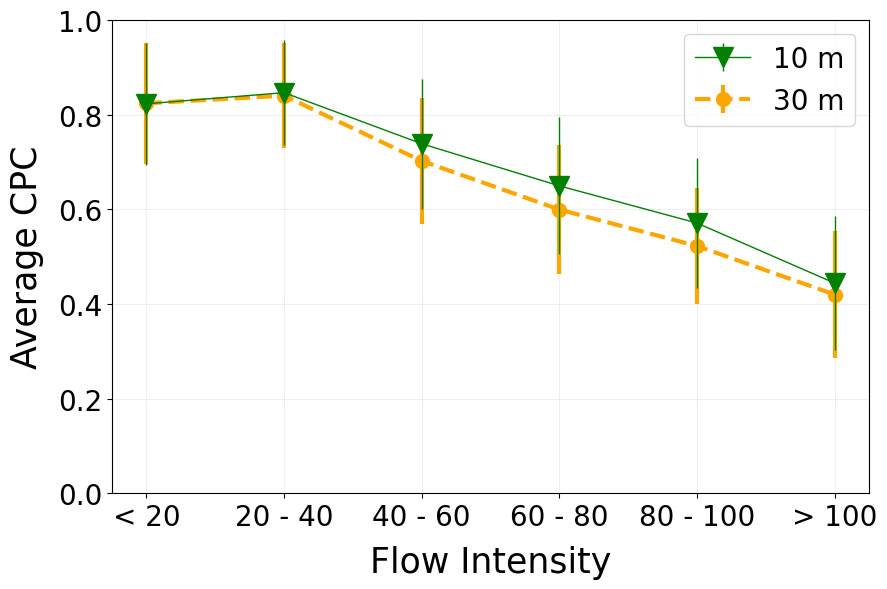

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import json
import seaborn as sns

save_name = './M1_fig/M1_flowIntensity.png'

column_name = 'cut_intensity'
axisx_label = 'Flow Intensity'
# [11.0, 23.0, 47.0, 94.0, 231.0, 861.0]
x_ticklabels = [ '< 20','20 - 40', '40 - 60', '60 - 80', '80 - 100', '> 100']

x_ticks = len(x_ticklabels)

fig, ax = plt.subplots(1, 1, figsize=(9, 6), sharex=True)
df = res_total
avg_r1ws,avg_s2s,avg_l8s = [], [], []
std_r1ws,std_s2s,std_l8s = [], [], []
for decile in sorted(df[column_name].unique()):
      df_temp = df[df[column_name] == decile]

      # avg_r1w = df_temp.h_cpc_r1w.mean()
      avg_s2 = df_temp.f_cpc_s2.mean()
      avg_l8 = df_temp.f_cpc_l8.mean()
      

      # avg_r1ws.append(avg_r1w)
      avg_s2s.append(avg_s2)
      avg_l8s.append(avg_l8)

      # std_r1w = df_temp.h_cpc_r1w.std()
      std_s2 = df_temp.f_cpc_s2.std()
      std_l8 = df_temp.f_cpc_l8.std()

      # std_r1ws.append(std_r1w)
      std_s2s.append(std_s2)
      std_l8s.append(std_l8)

      table = table.append({'decile':decile,
                  'count':len(df_temp),
               #    'CPC r1w mean':avg_r1w,
                  'CPC s2 mean':avg_s2,
                  'CPC l8 mean':avg_l8}
                  ,ignore_index=True)

ax.errorbar(range(x_ticks), avg_s2s, yerr=std_s2s, marker='v',
         color='green', label='10 m', linewidth=1, markersize=15, zorder=3)  

ax.errorbar(range(x_ticks), avg_l8s, yerr=std_l8s, marker='o',markersize=10,
         color='orange', label='30 m', linestyle='--', linewidth=3)  

ax.set_ylabel('Average CPC', fontsize=25, labelpad=10)
ax.set_xlabel(axisx_label, fontsize=25, labelpad=10)
ax.set_xticks(range(x_ticks))
ax.set_xticklabels(x_ticklabels)

ax.set_ylim(0,1)
ax.tick_params(labelsize=20)
ax.grid(alpha=0.2)
# ax.set_title(country_to_subid[country][0], fontsize=30)
ax.legend(fontsize=20, loc='upper right')

plt.subplots_adjust(wspace=0.3)
#fig.suptitle(country2long_name[country], fontsize=20)
plt.tight_layout()
plt.savefig(save_name)

# home cpc spatial error

In [49]:
home_sum.reset_index(inplace=True)
home_sum['h_geocode_str'] = home_sum['h_geocode'].apply(lambda x: ('\''+x))
home_sum['error_s2'] = (home_sum['prediction_s2'] - home_sum['count']) / home_sum['count']
home_sum['error_l8'] = (home_sum['prediction_l8'] - home_sum['count']) / home_sum['count']
home_sum

,index,h_geocode,count,prediction_s2,prediction_l8,common_s2,common_l8,population,decile,LC,h_cpc_s2,h_cpc_l8,LU,error_s2,error_l8,h_geocode_str
0,0,34003001001,313.0,489.406306,450.361290,301.391786,313.000000,3363.0,7.0,VALUE_21,0.751220,0.820057,VALUE_6,0.563598,0.438854,'34003001001
1,1,34003001002,372.0,448.082289,568.911912,315.186548,337.350900,3485.0,7.0,VALUE_21,0.768671,0.717072,VALUE_6,0.204522,0.529333,'34003001002
2,2,34003002100,92.0,95.224959,106.271005,86.063395,90.829836,1762.0,10.0,SUM_4,0.919358,0.916219,VALUE_6,0.035054,0.155120,'34003002100
3,3,34003002200,762.0,703.684171,830.537154,495.934703,519.016789,5168.0,3.0,SUM_22_23_24,0.676728,0.651811,VALUE_6,-0.076530,0.089944,'34003002200
4,4,34003002300,843.0,680.429246,731.949966,555.363049,561.592823,5641.0,2.0,VALUE_21,0.729096,0.713156,VALUE_6,-0.192848,-0.131732,'34003002300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4781,4781,42103950804,97.0,133.737458,227.830450,93.613148,97.000000,3727.0,6.0,SUM_4,0.811426,0.597235,UNKNOWN,0.378737,1.348768,'42103950804
4782,4782,42103950805,43.0,35.867070,54.171688,35.867070,43.000000,2903.0,8.0,SUM_4,0.909558,0.885031,VALUE_6,-0.165882,0.259807,'42103950805
4783,4783,42103950806,68.0,78.367871,130.619160,65.936665,68.000000,2783.0,8.0,SUM_4,0.900972,0.684727,UNKNOWN,0.152469,0.920870,'42103950806
4784,4784,42103950901,122.0,154.421312,116.627213,109.732735,103.564583,2512.0,9.0,SUM_4,0.793953,0.868003,VALUE_6,0.265748,-0.044039,'42103950901


In [46]:
# home_sum.drop(columns='index', inplace=True)

In [50]:
home_sum.to_csv('home_decile_cpc_M1_sub512_log2LB_#layers2_emb512.csv')